# Анализ эффективности системы сплитования 

Задача проверить, корректно ли работает наша система сплитования и убедиться, что ключевая метрика не отличается между группами не только в конкретно нашем АА-тесте, но и в целом между группами.

Т.к. мы знаем что у нас будет проводиться два теста систем рекомендация между группами 1 и 2, а также между группами 0 и 3. Для этого сначала сравним между собой целевые группы, нет ли там различий между `ctr`, а далее проведем АА тесты между группами 1 и 2, 0 и 3.

Для этого проведем `t-тест` 10000 раз на наших группах и оценим их распределение получившихся значений `p-value`

---

Выполняем импортирование нужных библиотек

In [2]:
import pandahouse as ph
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

### АА тест между группами 2 и 3

Подключаемся к `clickhouse` и вытягиваем экспериментальную группу пользователя, его`id`, его количество лайков, количество просмотров и `ctr` каждого пользователя 

In [3]:
connection = {
                'host': 'https://clickhouse.lab.karpov.courses',
                'database':'simulator_20230520',
                'user':'student', 
                'password':'dpo_python_2020'
            }

query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''


# Выполняем запрос к БД
df = ph.read_clickhouse(query, connection=connection)

Посмотрим сколько пользователей у нас попало в группы и их статистику

In [4]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Убедимся в корректности работы нашей системы сплитования. Для этого проведем АА тест 10000 раз, будем использовать t-тест Стьюдента.

Для этого будем извлекать из каждой группы случайно по 250 человек и проводить тест. Далее сформируем список с результатами теста, куда будем складывать получившееся значение `p-value`

In [5]:
results = []
for _ in range(10000):
    group_2 = df[df['exp_group']==2]['ctr'].sample(n=250)
    group_3 = df[df['exp_group']==3]['ctr'].sample(n=250)
    res = stats.ttest_ind(group_2, group_3, equal_var=False)
    results.append(res[1])

Выполним визуализацию полученных результатов

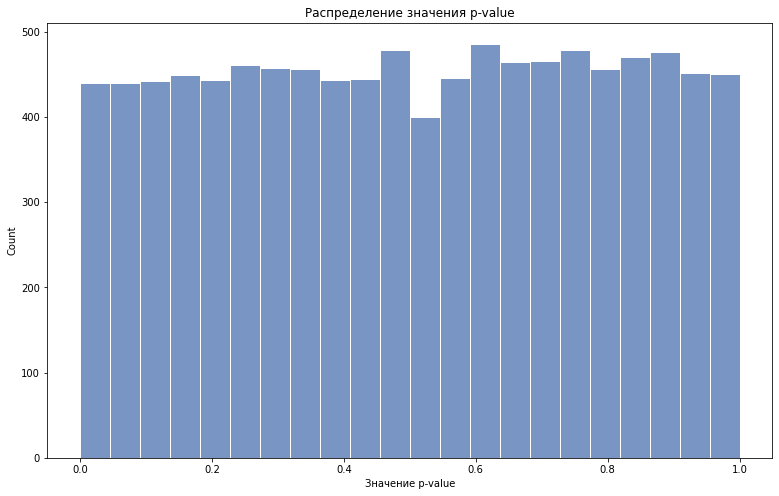

In [6]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
sns.histplot(results)
plt.title("Распределение значения p-value")
plt.xlabel("Значение p-value")
plt.show()

Как мы видим, наше значение `p-value` распределено равномерно

Посчитаем, сколько раз встречалось значение `p-value` больше 0.05% для того, чтобы понять, корректно ли работает наша система сплитования и различия в `ctr` двух групп получены случайным образом. Т.е. мы ожидаем, что в большинстве раз наш тест будет давать результат, где `p-value` больше 0.05%

In [7]:
print(f'% количества наблюдений при p-value > 0.05%: {round(len([i for i in results if i>0.05]) * 100/ len(results),2)}')

% количества наблюдений при p-value > 0.05%: 95.19


---

***Вывод:*** наша система сплитования работает корректно, т.к. в 95% тестов мы получили результат p_value > 0.05%, что говорит о том, что недостаточно оснований отклонить нулевую гипотезу. Можно считать, что АА тест прошел успешно.

### АА тест между группами 1 и 2

Вытягиваем данные для групп 2 и 3

In [9]:
query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''


# Выполняем запрос к БД
df_1_2 = ph.read_clickhouse(query, connection=connection)

Выполним `t-тест` между группами 100000 раз и оценим получившиеся значения `p-value`

In [10]:
results_1_2 = []
for _ in range(10000):
    group_1 = df_1_2[df_1_2['exp_group']==1]['ctr'].sample(n=250)
    group_2 = df_1_2[df_1_2['exp_group']==2]['ctr'].sample(n=250)
    res = stats.ttest_ind(group_1, group_2, equal_var=False)
    results_1_2.append(res[1])

Выполним визуализацию полученных результатов

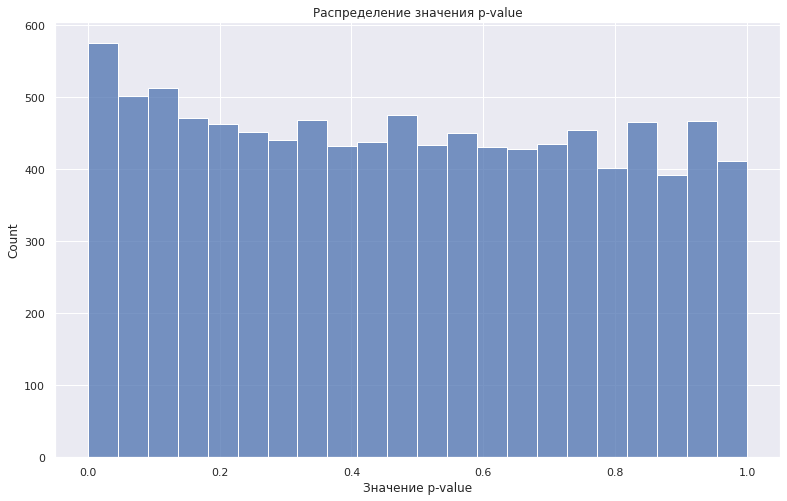

In [11]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
sns.histplot(results_1_2)
plt.title("Распределение значения p-value")
plt.xlabel("Значение p-value")
plt.show()

Как мы видим распределение равномерное, однако его характер отличается от сравнения между группами 2 и 3. В данном распределении максимум значений как раз таки приходится около ~0

Определим количество наблидений при `p-value` > 0.05%

In [12]:
print(f'% количества наблюдений при p-value > 0.05%: {round(len([i for i in results_1_2 if i>0.05]) * 100/ len(results_1_2),2)}')

% количества наблюдений при p-value > 0.05%: 93.75


***Вывод:*** наша система сплитования также хорошо работает и действительно отличий между группами нет.

---

### АА тест между группами 0 и 3

Вытягиваем данные для групп 0 и 3

In [13]:
query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-04-24' and '2023-04-30'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
'''


# Выполняем запрос к БД
df_0_3 = ph.read_clickhouse(query, connection=connection)

Выполним `t-тест` между группами 100000 раз и оценим получившиеся значения `p-value`

In [15]:
results_0_3 = []
for _ in range(10000):
    group_1 = df_0_3[df_0_3['exp_group']==0]['ctr'].sample(n=250)
    group_2 = df_0_3[df_0_3['exp_group']==3]['ctr'].sample(n=250)
    res = stats.ttest_ind(group_1, group_2, equal_var=False)
    results_0_3.append(res[1])

Выполним визуализацию полученных результатов

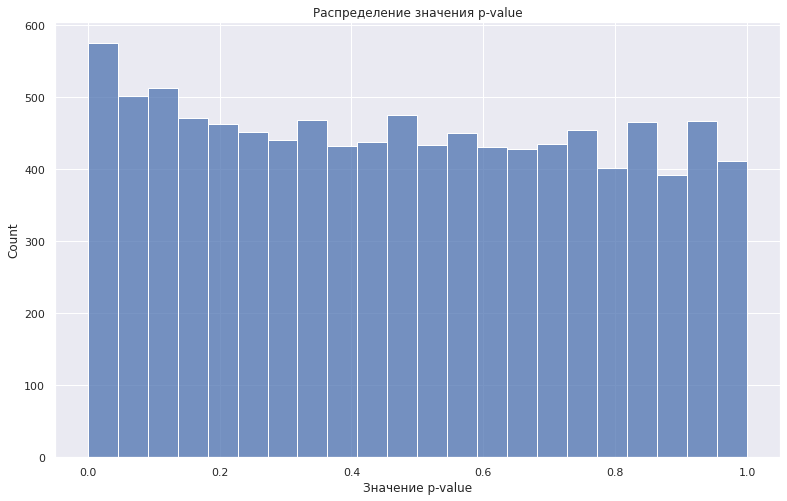

In [16]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
sns.histplot(results_1_2)
plt.title("Распределение значения p-value")
plt.xlabel("Значение p-value")
plt.show()

Определим количество наблидений при `p-value` > 0.05%

In [17]:
print(f'% количества наблюдений при p-value > 0.05%: {round(len([i for i in results_0_3 if i>0.05]) * 100/ len(results_0_3),2)}')

% количества наблюдений при p-value > 0.05%: 95.06


***Вывод:*** мы убедились, что отличий между группами нет, т.к. БОЛЬШЕЕ количество значений `p-value` > 0.05%